In [1]:
import re 
import pandas as pd 
from time import time  
from collections import defaultdict  

In [2]:
import spacy  

import logging 
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
df = pd.read_csv('/content/dataset (1).csv')
df.shape

(27, 2)

In [5]:
df.head()

,code,explanation
0,NaN,NaN
1,"int main() {printf(""Hello, World!""); return 0;}","The code prints the string ""Hello, World!""."
2,"int main() {scanf(""%d"",&n); printf(""%d"",n); re...",The code scans the value of n and then prints ...
3,"int main() {scanf(""%d"",&m); printf(""%d"",m); re...",The code scans the value of m and then prints ...
4,"int main() {printf(""Himanshu""); return 0;}","The code prints the string ""Himanshu""."


In [6]:
df.isnull().sum()

code           2
explanation    4
dtype: int64

In [7]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

code           0
explanation    0
dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)


In [9]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['explanation'])


In [10]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.0 mins


In [11]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(22, 1)

In [12]:
from gensim.models.phrases import Phrases, Phraser

In [13]:
sent = [row.split() for row in df_clean['clean']]


In [14]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [15]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [16]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

43

In [17]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['value', 'code', 'print', 'scan', 'b', 'c', "'", 'sum', 'assign', 'string']

In [18]:
import multiprocessing

from gensim.models import Word2Vec

In [19]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [20]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                      workers=cores-1)

In [21]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [22]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.0 mins


In [23]:
w2v_model.init_sims(replace=True)


<ipython-input-23-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [24]:
w2v_model.wv.most_similar(positive=["string"])


[('x', 0.12529587745666504),
 ('value', 0.11045122891664505),
 ("'", 0.10891108959913254),
 ('check', 0.09878621995449066),
 ('m', 0.08243879675865173),
 ('code', 0.06600061804056168),
 ('hello', 0.05713500455021858),
 ('programming', 0.042763981968164444),
 ('yes', 0.04138921946287155),
 ('divisible', 0.040869440883398056)]

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [26]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=5).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                    'y': [y for y in Y[:, 1]],
                    'words': word_labels,
                    'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                   )
    for line in range(0, df.shape[0]):
                p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [27]:
df.shape[0]

23

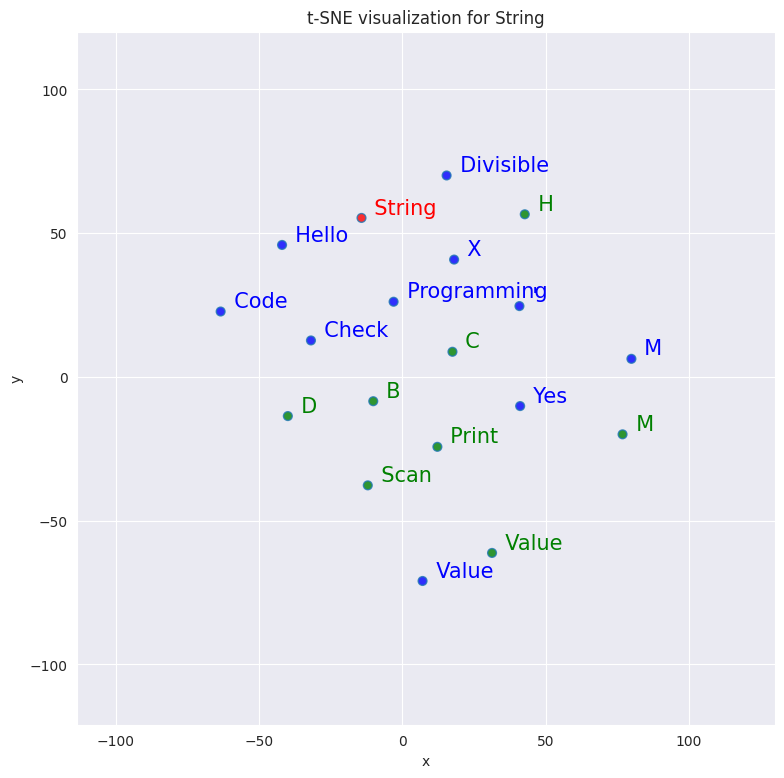

In [28]:
tsnescatterplot(w2v_model, 'string', ['c', 'h', 'print', 'm', 'value', 'b', 'd', 'scan'])

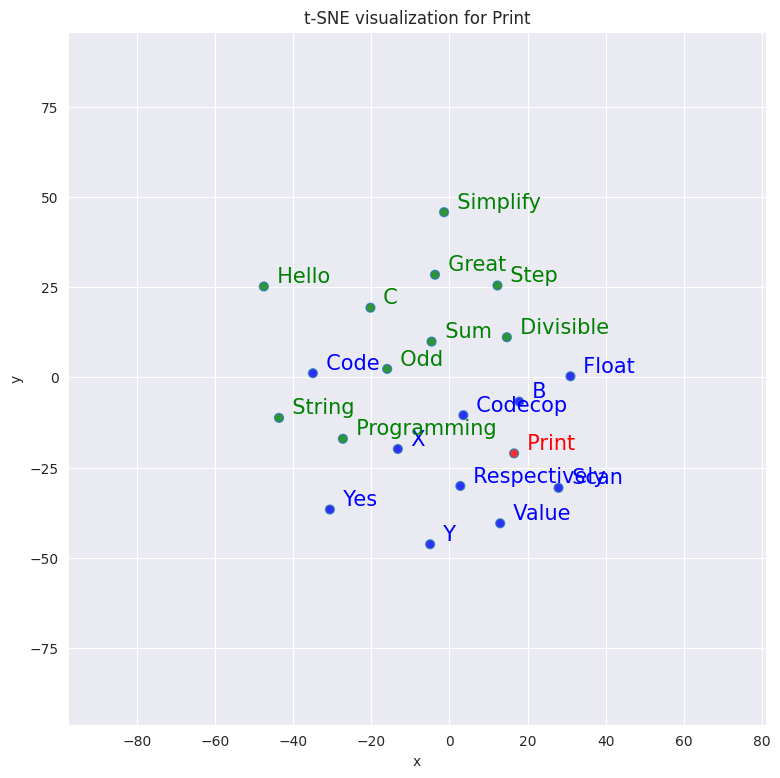

In [38]:
tsnescatterplot(w2v_model, 'print', [i[0] for i in w2v_model.wv.most_similar(negative=["print"])])